# import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
import time
import sys
import platform

In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import noise
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter

# Environment

In [3]:
# device version
pprint(platform.machine())
pprint(platform.version())
pprint(platform.platform())
pprint(platform.uname())
pprint(platform.system())
pprint(platform.processor())

'x86_64'
('Darwin Kernel Version 19.5.0: Tue May 26 20:41:44 PDT 2020; '
 'root:xnu-6153.121.2~2/RELEASE_X86_64')
'Darwin-19.5.0-x86_64-i386-64bit'
uname_result(system='Darwin', node='Yang-no-MBP', release='19.5.0', version='Darwin Kernel Version 19.5.0: Tue May 26 20:41:44 PDT 2020; root:xnu-6153.121.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
'Darwin'
'i386'


In [4]:
# python version
pprint(sys.version)

('3.7.7 (default, May  6 2020, 04:59:01) \n'
 '[Clang 4.0.1 (tags/RELEASE_401/final)]')


In [5]:
# qiskit version
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.1'}

# Measure the time of tensored calibration for GHZ state from size 2 to 7
- Testing for "least_squares" method
- Using the original TensoredFilter.apply() function

In [6]:
lim = 8
times = []
noisy_counts_of_each_size = []
mitigated_counts_of_each_size = []

In [7]:
for n in range(2,lim):
    # n = 14
    print("experiment of ", n, "-qubit GHZ state")

    # create n qubit tensored measurement calibration circuits
    qr = qiskit.QuantumRegister(n)
    mit_pattern = [[i] for i in range(n)]
    meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
    print("mit pattern: ", mit_pattern)
    print("number of calibration circuits: ", len(meas_calibs), "-> the circuits for '000...0' and '111...1'")

    # prepare noise model of n qubits
    noise_model = noise.NoiseModel()
    for qi in range(n):
        read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
        noise_model.add_readout_error(read_err, [qi])

    # execute the calibration circuits
    job = qiskit.execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=5000, noise_model=noise_model)
    cal_results = job.result()
    meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)
    print(meas_fitter.cal_matrices)

    # create n-qubit GHZ state
    m = n
    cr = ClassicalRegister(m)
    ghz = QuantumCircuit(qr, cr)
    ghz.h(qr[0])
    for i in range(1,m):
        ghz.cx(qr[0], qr[i])
    ghz.barrier()
    for i in range(m):
        ghz.measure(qr[i],cr[i])
    # ghz.draw("mpl")

    # execute GHZ circuit
    job = qiskit.execute([ghz], backend=Aer.get_backend("qasm_simulator"), shots=5000, noise_model=noise_model)
    noisy_counts = job.result().get_counts()

    # Get the filter object
    meas_filter = meas_fitter.filter

    t1 = time.time()
    # Results with mitigation
    mitigated_counts = meas_filter.apply(noisy_counts)
    t2 = time.time()

    print("time of mitigation for", n, "qubits GHZ state: ", t2 - t1, "[s]")
    times.append(t2 - t1)

    noisy_counts_of_each_size.append(noisy_counts)
    mitigated_counts_of_each_size.append(mitigated_counts)
    
    print()

experiment of  2 -qubit GHZ state
mit pattern:  [[0], [1]]
number of calibration circuits:  2 -> the circuits for '000...0' and '111...1'
[array([[0.8996, 0.2426],
       [0.1004, 0.7574]]), array([[0.9048, 0.2608],
       [0.0952, 0.7392]])]
time of mitigation for 2 qubits GHZ state:  0.006591081619262695 [s]

experiment of  3 -qubit GHZ state
mit pattern:  [[0], [1], [2]]
number of calibration circuits:  2 -> the circuits for '000...0' and '111...1'
[array([[0.8984, 0.2544],
       [0.1016, 0.7456]]), array([[0.8956, 0.2486],
       [0.1044, 0.7514]]), array([[0.8986, 0.258 ],
       [0.1014, 0.742 ]])]
time of mitigation for 3 qubits GHZ state:  0.046553850173950195 [s]

experiment of  4 -qubit GHZ state
mit pattern:  [[0], [1], [2], [3]]
number of calibration circuits:  2 -> the circuits for '000...0' and '111...1'
[array([[0.8974, 0.251 ],
       [0.1026, 0.749 ]]), array([[0.8964, 0.2546],
       [0.1036, 0.7454]]), array([[0.8986, 0.2582],
       [0.1014, 0.7418]]), array([[0.90

In [8]:
pprint(times)

[0.006591081619262695,
 0.046553850173950195,
 0.35661792755126953,
 4.983950138092041,
 52.25950884819031,
 292.9440441131592]


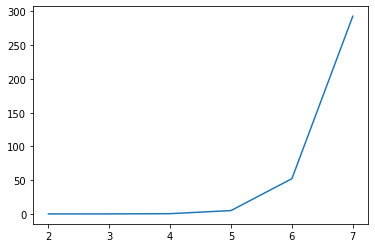

In [9]:
plt.plot(range(2, lim), times)

# Check whether the mitigation is done successfully

2 -qubit GHZ state


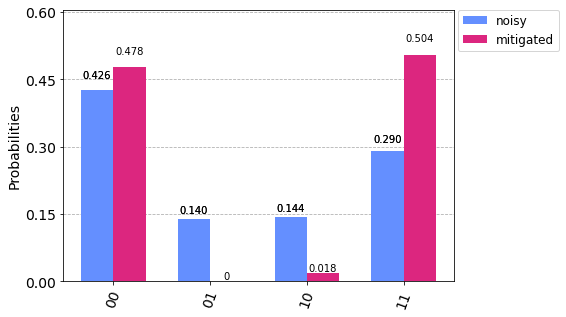

In [10]:
print(0 + 2, "-qubit GHZ state")
plot_histogram([noisy_counts_of_each_size[0], mitigated_counts_of_each_size[0]], legend=['noisy', 'mitigated'])

3 -qubit GHZ state


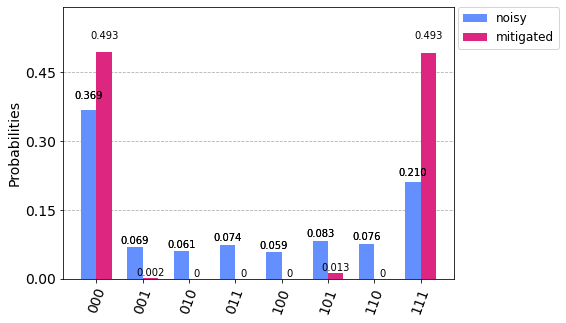

In [11]:
print(1 + 2, "-qubit GHZ state")
plot_histogram([noisy_counts_of_each_size[1], mitigated_counts_of_each_size[1]], legend=['noisy', 'mitigated'])

4 -qubit GHZ state


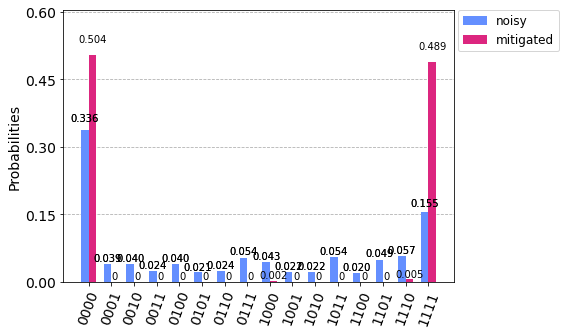

In [12]:
print(2 + 2, "-qubit GHZ state")
plot_histogram([noisy_counts_of_each_size[2], mitigated_counts_of_each_size[2]], legend=['noisy', 'mitigated'])

5 -qubit GHZ state


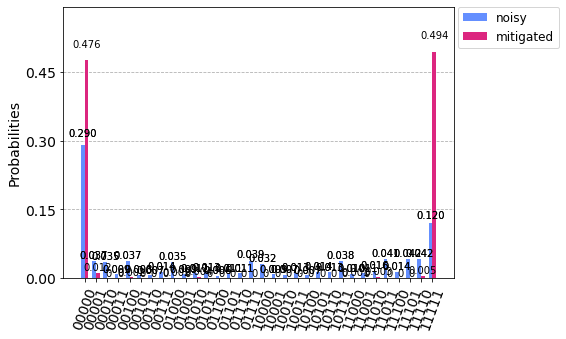

In [13]:
print(3 + 2, "-qubit GHZ state")
plot_histogram([noisy_counts_of_each_size[3], mitigated_counts_of_each_size[3]], legend=['noisy', 'mitigated'])

6 -qubit GHZ state


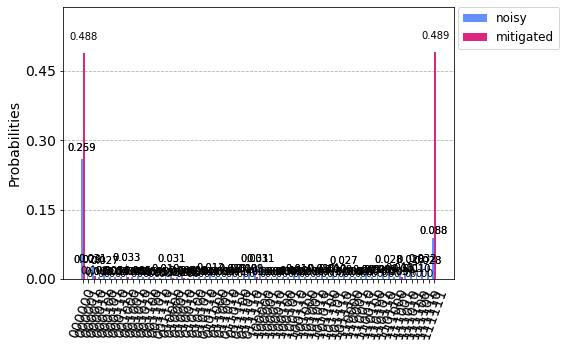

In [14]:
print(4 + 2, "-qubit GHZ state")
plot_histogram([noisy_counts_of_each_size[4], mitigated_counts_of_each_size[4]], legend=['noisy', 'mitigated'])

7 -qubit GHZ state


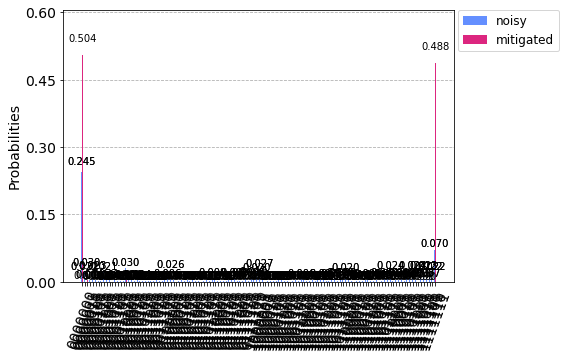

In [15]:
print(5 + 2, "-qubit GHZ state")
plot_histogram([noisy_counts_of_each_size[5], mitigated_counts_of_each_size[5]], legend=['noisy', 'mitigated'])